In [109]:
import numpy as np
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import os
import treecorr
import h5py

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [110]:
psf_files = os.listdir('/project/chihway/data/decade/psf_cats')

In [111]:
T = []
T_mod = []
e1 = []
e1_mod = []
e2 = []
e2_mod = []
ra = []
dec = []
snr = []


for ff in psf_files[:10]:
    infile = pf.open('/project/chihway/data/decade/psf_cats/'+ff)[1].data
    mask = (infile['IMAFLAGS_ISO']==0)
    T.append(infile['T_star_hsm'][mask])
    T_mod.append(infile['T_model_hsm'][mask])
    e1.append(infile['g1_star_hsm'][mask])
    e1_mod.append(infile['g1_model_hsm'][mask])
    e2.append(infile['g2_star_hsm'][mask])
    e2_mod.append(infile['g2_model_hsm'][mask])
    ra.append(infile['ra'][mask])
    dec.append(infile['dec'][mask])
    snr.append(infile['FLUX_APER_8'][mask]/infile['FLUXERR_APER_8'][mask])
    

/home/chihway/ipykernel_3775214/3518708404.py:23: RuntimeWarning: invalid value encountered in divide
  snr.append(infile['FLUX_APER_8'][mask]/infile['FLUXERR_APER_8'][mask])


In [112]:
T = np.hstack(np.array(T))
T_mod = np.hstack(np.array(T_mod))
e1 = np.hstack(np.array(e1))
e1_mod = np.hstack(np.array(e1_mod))
e2 = np.hstack(np.array(e2))
e2_mod = np.hstack(np.array(e2_mod))
ra = np.hstack(np.array(ra))
dec = np.hstack(np.array(dec))
snr = np.hstack(np.array(snr))

/home/chihway/ipykernel_3775214/3551877762.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T = np.hstack(np.array(T))
/home/chihway/ipykernel_3775214/3551877762.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T_mod = np.hstack(np.array(T_mod))
/home/chihway/ipykernel_3775214/3551877762.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

In [113]:
d_e1_psf = e1-e1_mod
d_e2_psf = e2-e2_mod
d_T1_psf = e1*(T-T_mod)/T
d_T2_psf = e2*(T-T_mod)/T


d_e1_psf = np.nan_to_num(d_e1_psf)
d_e2_psf = np.nan_to_num(d_e2_psf)
d_T1_psf = np.nan_to_num(d_T1_psf)
d_T2_psf = np.nan_to_num(d_T2_psf)

mask = (d_e1_psf!=0)*(d_e2_psf!=0)*(d_T1_psf!=0)*(d_T2_psf!=0) #*(snr>40)

d_e1_psf = d_e1_psf[mask]
d_e2_psf = d_e2_psf[mask]
ra_psf = ra[mask]
dec_psf = dec[mask]
snr_psf = snr[mask]
e1_star = e1[mask]
e2_star = e2[mask]
e1_psf = e1_mod[mask]
e2_psf = e2_mod[mask]
w1 = d_T1_psf[mask]
w2 = d_T1_psf[mask]

In [114]:
with h5py.File('/project/chihway/data/decade/metacal_test_1000tiles_20221108_all.hdf') as f:
    ra_gal = f['DATA/ra'][:]
    dec_gal = f['DATA/dec'][:]
    g1_gal = f['DATA/mcal_g_noshear'][:,0]
    g2_gal = f['DATA/mcal_g_noshear'][:,1]

## !!! still need to calibrate this !!!

In [115]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

tau2p = gg.xip
tau2m = gg.xim


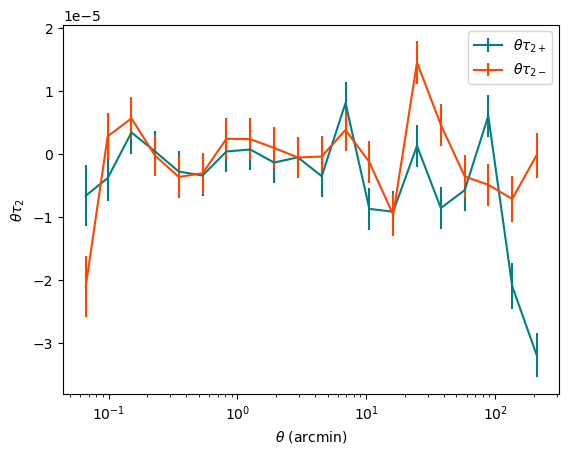

In [116]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\tau_{2+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\tau_{2-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{2}$')
mplot.legend()

In [117]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

tau0p = gg.xip
tau0m = gg.xim


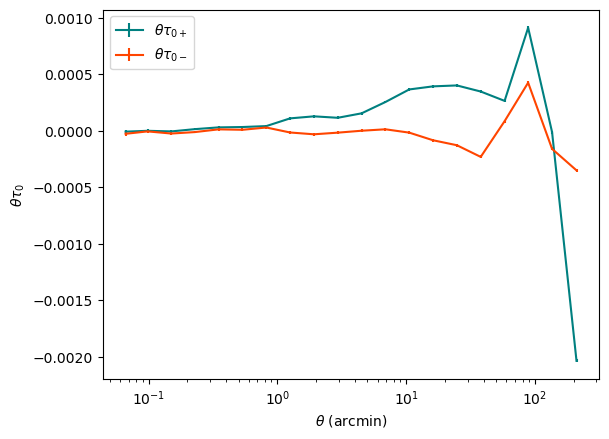

In [118]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\tau_{0+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\tau_{0-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{0}$')
mplot.legend()

In [119]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

tau5p = gg.xip
tau5m = gg.xim


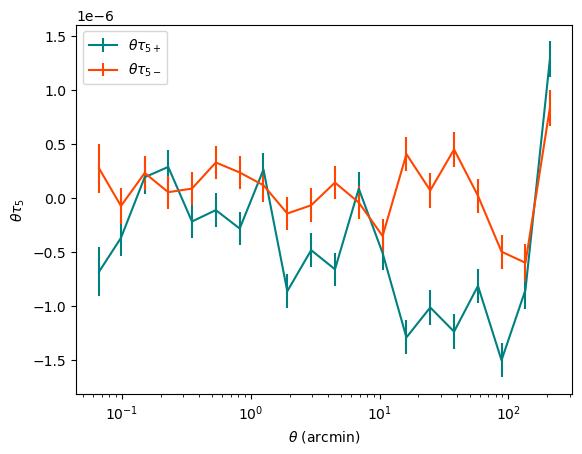

In [120]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\tau_{5+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\tau_{5-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{5}$')
mplot.legend()

## Also calculate the rho stats to get alpha beta gamma

In [121]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

rho0p = gg.xip
rho0m = gg.xim

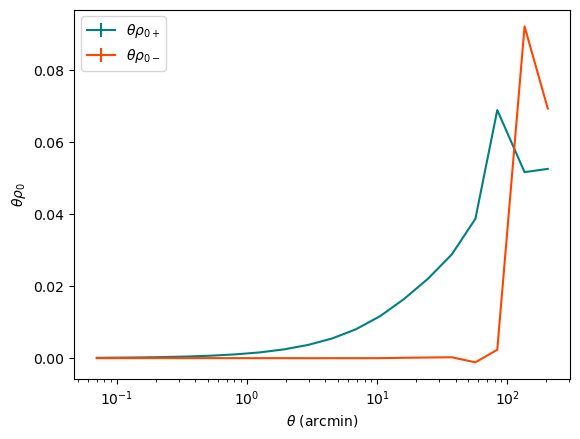

In [122]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\rho_{0+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\rho_{0-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\rho_{0}$')
mplot.legend()

In [123]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

rho1p = gg.xip
rho1m = gg.xim

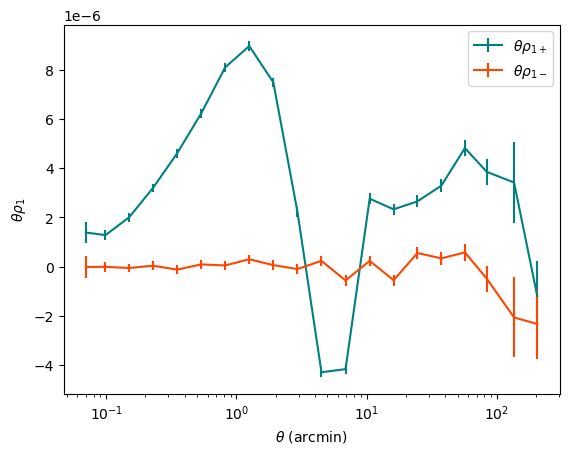

In [124]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\rho_{1+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\rho_{1-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\rho_{1}$')
mplot.legend()

In [125]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

rho2p = gg.xip
rho2m = gg.xim

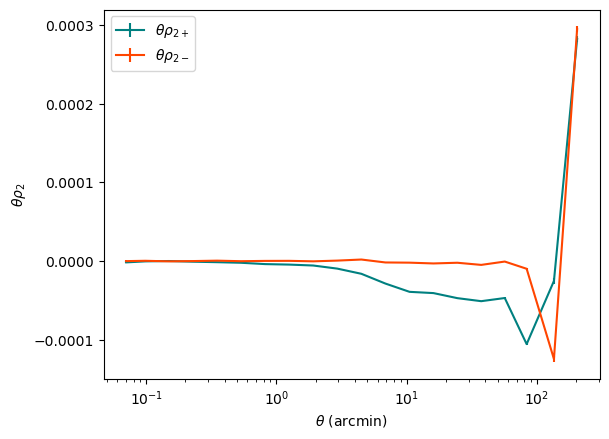

In [126]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\rho_{2+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\rho_{2-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\rho_{2}$')
mplot.legend()

In [127]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

rho3p = gg.xip
rho3m = gg.xim

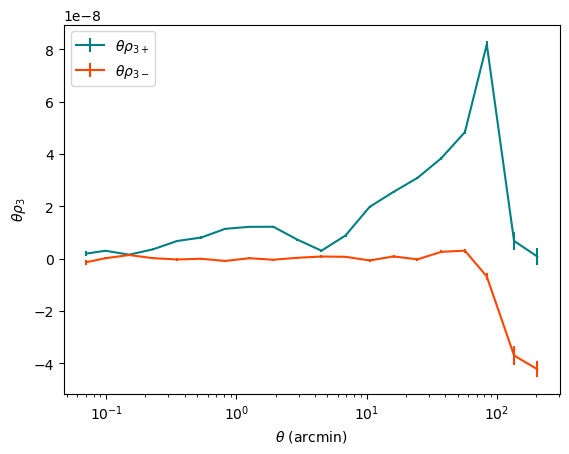

In [128]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\rho_{3+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\rho_{3-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\rho_{3}$')
mplot.legend()

In [129]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)

gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

rho4p = gg.xip
rho4m = gg.xim

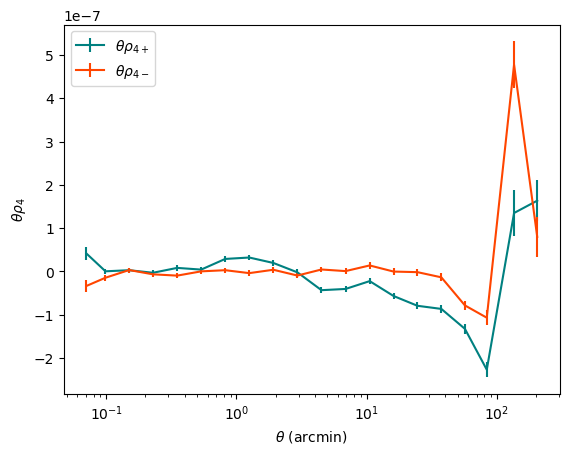

In [130]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\rho_{4+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\rho_{4-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\rho_{4}$')
mplot.legend()

In [131]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)

gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function
theta = np.exp(gg.meanlogr)

rho5p = gg.xip
rho5m = gg.xim

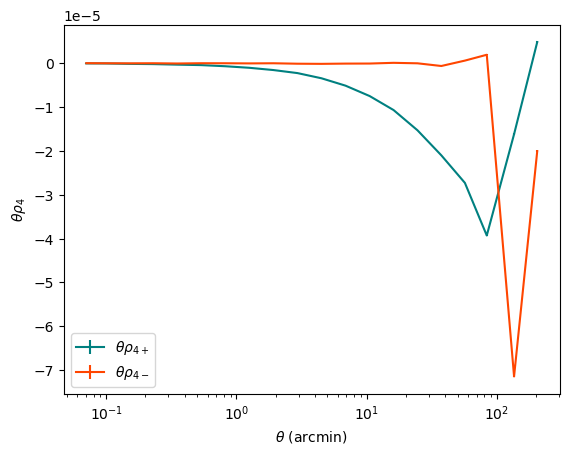

In [132]:
mplot.errorbar(theta, theta*xip, theta*gg.varxip**0.5, color='teal', label='$\\theta \\rho_{4+}$')
mplot.errorbar(theta, theta*xim, theta*gg.varxim**0.5, color='orangered', label='$\\theta \\rho_{4-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\rho_{4}$')
mplot.legend()

In [133]:
Alpha = []
Beta = []
Gamma = []
for i in range(20):
    A = np.array([[rho0p[i], rho2p[i], rho5p[i]], [rho2p[i], rho1p[i], rho4p[i]],[rho5p[i], rho4p[i], rho3p[i]]])
    B = np.array([tau0p[i], tau2p[i], tau5p[i]])
    X = np.linalg.solve(A, B)
    Alpha.append(X[0])
    Beta.append(X[1])
    Gamma.append(X[2])
    

(array([1., 0., 0., 0., 1., 0., 0., 0., 2., 1., 1., 2., 4., 0., 2., 2., 1.,
        0., 2., 1.]),
 array([-0.16546123, -0.15193073, -0.13840024, -0.12486974, -0.11133924,
        -0.09780874, -0.08427824, -0.07074774, -0.05721724, -0.04368674,
        -0.03015624, -0.01662575, -0.00309525,  0.01043525,  0.02396575,
         0.03749625,  0.05102675,  0.06455725,  0.07808775,  0.09161824,
         0.10514874]),
 <BarContainer object of 20 artists>)

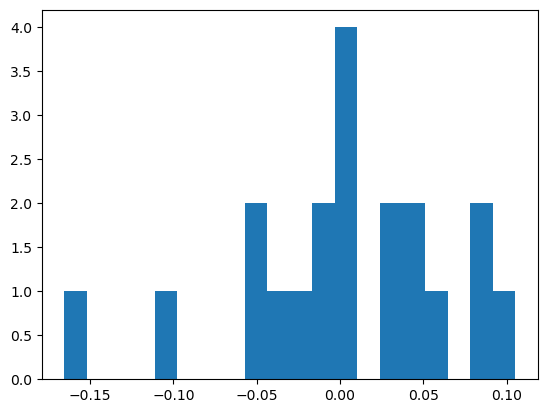

In [134]:
mplot.hist(Alpha, bins=20)

(array([2., 1., 0., 4., 0., 7., 2., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 array([-7.06223778, -5.85941229, -4.65658681, -3.45376132, -2.25093584,
        -1.04811035,  0.15471514,  1.35754062,  2.56036611,  3.76319159,
         4.96601708,  6.16884256,  7.37166805,  8.57449353,  9.77731902,
        10.9801445 , 12.18296999, 13.38579547, 14.58862096, 15.79144644,
        16.99427193]),
 <BarContainer object of 20 artists>)

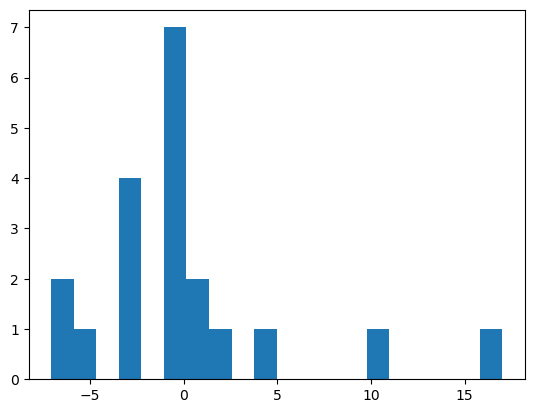

In [135]:
mplot.hist(Beta, bins=20)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 4., 7.,
        3., 1., 2.]),
 array([-731.75575858, -688.95364288, -646.15152718, -603.34941148,
        -560.54729578, -517.74518008, -474.94306439, -432.14094869,
        -389.33883299, -346.53671729, -303.73460159, -260.93248589,
        -218.13037019, -175.32825449, -132.52613879,  -89.72402309,
         -46.92190739,   -4.11979169,   38.68232401,   81.48443971,
         124.2865554 ]),
 <BarContainer object of 20 artists>)

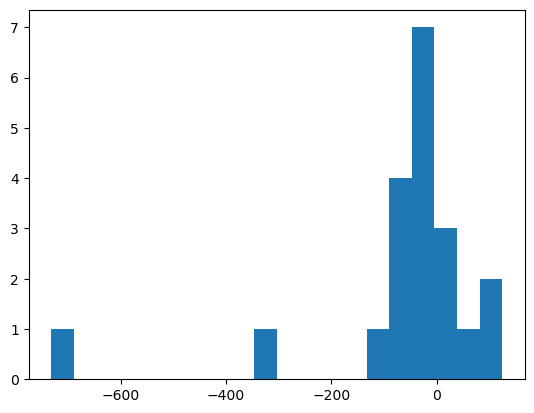

In [136]:
mplot.hist(Gamma, bins=20)